# Code to Adjust Offensive, Defensive and Net Ratings for Strength of Schedule

In [52]:
import json
from sklearn.linear_model import RidgeCV
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *
import pandas as pd
import scipy
import seaborn as sns
sns.set(style='whitegrid') 
# from sklearn.pipeline import make_pipeline
# model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

team_data = pd.read_csv("../data/NBA_teams_database.csv") 
teams_list = team_data["TeamID"].tolist()
team_dict1 = team_data.to_dict(orient="records")
teams_dict = {team["TeamID"]:team["Team"] for team in team_dict1}

# Get Ratings Function:
1. Reads Advanced Box Scores from csv file
2. Groups two entries for a single game (team1 and team2)
3. Splits columns for team1 and team2 for team1
4. Splits columns for team1 and team2 for team2
5. Combines the split data to get back two entries for single game with appropriate opposition information and stats
6. Returns the combined data

In [2]:
def get_ratings(season=2023):
    df1 = pd.read_csv(f"NBA_Adv_BoxScores_{season}.csv")
    cols = ["gameId","teamName","teamId","offensiveRating","defensiveRating","netRating","possessions"]
    df2 = df1[cols]
    df2.iloc[:,2:]=df2.iloc[:,2:].astype(str)
    df3 = df2.groupby("gameId")[cols[1:]].agg(", ".join).reset_index()
    df4 = df3.copy()
    df4[["team1","team2"]] = df3["teamName"].str.split(",",expand=True)
    df4[["tId1","tId2"]] = df3["teamId"].str.split(",",expand=True)
    df4[["ORtg1","ORtg2"]] = df3["offensiveRating"].str.split(",",expand=True)
    df4[["DRtg1","DRtg2"]] = df3["defensiveRating"].str.split(",",expand=True)
    df4[["NRtg1","NRtg2"]] = df3["netRating"].str.split(",",expand=True)
    df4[["poss1","poss2"]] = df3["possessions"].str.split(",",expand=True)
    df4 = df4.drop(columns=cols[1:])
    df5 = df3.copy()
    df5[["team2","team1"]] = df3["teamName"].str.split(",",expand=True)
    df5[["tId2","tId1"]] = df3["teamId"].str.split(",",expand=True)
    df5[["ORtg2","ORtg1"]] = df3["offensiveRating"].str.split(",",expand=True)
    df5[["DRtg2","DRtg1"]] = df3["defensiveRating"].str.split(",",expand=True)
    df5[["NRtg2","NRtg1"]] = df3["netRating"].str.split(",",expand=True)
    df5[["poss2","poss1"]] = df3["possessions"].str.split(",",expand=True)
    df5 = df5.drop(columns=cols[1:])
    df6 = pd.concat([df4,df5]).sort_values(by="gameId").reset_index(drop=True)
    df6.iloc[:,5:]=df6.iloc[:,5:].astype(float)
    df6.iloc[:,3:5]=df6.iloc[:,3:5].astype(int)
    data = df6.copy()
    return data

# Process Results Function
1. Calculates Offensive, Defensive and Net Ratings from data
2. Merges Regression results with data (combine adjusted and unadjusted ratings)
3. Round all results
4. Calculate SOS values
5. Return results after cleaning and sorting

In [54]:
def process_results(data,results_adj):
    data["pts1"] = data["ORtg1"] * data["poss1"]
    data["pts2"] = data["DRtg1"] * data["poss1"]
    off_prior = data.groupby(["tId1"])[["poss1","pts1"]].agg("sum").reset_index()
    def_prior = data.groupby(["tId1"])[["poss1","pts2"]].agg("sum").reset_index()
    off_prior["OFF"] = off_prior["pts1"] / off_prior["poss1"] 
    off_prior = off_prior[["tId1","OFF"]]
    def_prior["DEF"] = def_prior["pts2"] / def_prior["poss1"] 
    def_prior = def_prior[["tId1","DEF"]]
    results_net = pd.merge(off_prior,def_prior,on=["tId1"])
    results_net["NET"] = results_net["OFF"] - results_net["DEF"] 
    results_net.rename(columns={"tId1":"tId"},inplace=True)
    results_net = results_net.astype(float).round(2)
    results_net["tId"] = results_net["tId"].astype(int)
    ortg_mean = data["pts1"].sum()/data["poss1"].sum()
    drtg_mean = data["pts2"].sum()/data["poss1"].sum()
    results_adj["aOFF"] = results_adj["aOFF"]
    results_adj["aDEF"] = results_adj["aDEF"]
    results_adj.iloc[:,2:] = results_adj.iloc[:,2:].round(2)
    results_adj["tId"] = results_adj["tId"].astype(int)
    results_comb = pd.merge(results_net,results_adj,on=["tId"])
    results_comb["oSOS"] = results_comb["aOFF"] -results_comb["OFF"]
    results_comb["dSOS"] = results_comb["DEF"] -results_comb["aDEF"]
    results_comb["SOS"] = results_comb["oSOS"] + results_comb["dSOS"]
    results_comb.iloc[:,2:] = results_comb.iloc[:,2:].round(2)
    results_comb = results_comb[["Team","OFF","oSOS","aOFF","DEF","dSOS","aDEF","NET","SOS","aNET"]]
    results = results_comb[["Team","OFF","DEF","NET","aOFF","aDEF","aNET"]]
    results = results.sort_values(by="aNET",ascending=0).reset_index(drop=True)
    return results,ortg_mean,drtg_mean

# maps_teams function
1. Makes the matrix rows to be used in ridge regression
2. The weights for each team = 1/2
3. Equations per game are:  
0.5*team1off_est + 0.5*team2def_est = team1offrating  
0.5*team2off_est + 0.5*team1def_est = team2offrating
4. The reason for doing this is that for unadjusted values of a game, team1offrating = team2defrating.  
So team1offrating = 0.5*team1offrating + 0.5*team2defrating. Therefore I use a similar structure for estimating adjusted ratings
# convert_to_matrices
1. Converts each row of data dataframe to x stints.
2. Then maps those rows using `map_teams` function to get matrix X rows
3. Gets Y rows
# lambda_to_alpha
Converts lambda value to alpha needed for ridge CV
# calculate_netrtg
1. Converts lambdas to alphas using `lambda_to_alpha` function
2. Defines the ridge regression problem using `scikit-learn`'s `RidgeCV` algorithm
3. `cv=5` is chosen i.e. kfold cross-validation splitting strategy using `k=5`
4. `Intercept` is set as true. This value is to be added later to our estimation results to get Offensive and Defensive ratings.
5. Gets coefficients and intercept
6. Add intercept to intercept to get adjusted ratings. Use adjusted off and def ratings to calculate adjusted net rating.
7. Create and return adjusted ratings dataframe

In [4]:
def map_teams(row_in, teams):
    t1 = row_in[0]
    t2 = row_in[1]
    rowOut = np.zeros([len(teams) * 2])
    rowOut[teams.index(t1)] = 1/2
    rowOut[teams.index(t2) + len(teams)] = 1/2
    return rowOut

def convert_to_matricies(possessions, name, teams):
    # extract only the columns we need

    # Convert the columns of player ids into a numpy matrix
    stints_x_base = possessions[['tId1', 'tId2']].to_numpy()
    # Apply our mapping function to the numpy matrix
    stint_X_rows = np.apply_along_axis(map_teams, 1, stints_x_base, teams)

    # Convert the column of target values into a numpy matrix
    stint_Y_rows = possessions[name].to_numpy()

    # return matricies and possessions series
    return stint_X_rows, stint_Y_rows
# Convert lambda value to alpha needed for ridge CV
def lambda_to_alpha(lambda_value, samples):
    return (lambda_value * samples) / 2.0

# Convert RidgeCV alpha back into a lambda value
def alpha_to_lambda(alpha_value, samples):
    return (alpha_value * 2.0) / samples

def calculate_netrtg(train_x, train_y, lambdas, teams_list):
    alphas = [lambda_to_alpha(l, train_x.shape[0]) for l in lambdas]
    # create a 5 fold CV ridgeCV model. Our target data is not centered at 0, so we want to fit to an intercept.
    clf = RidgeCV(alphas=alphas, cv=5, fit_intercept=True)

    # fit our training data
    model = clf.fit(train_x, train_y,)

    # convert our list of players into a mx1 matrix
    team_arr = np.transpose(np.array(teams_list).reshape(1, len(teams_list)))

    # extract our coefficients into the offensive and defensive parts
    coef_offensive_array = model.coef_[0:len(teams_list)][np.newaxis].T
    coef_defensive_array = model.coef_[len(teams_list):][np.newaxis].T

    # concatenate the offensive and defensive values with the playey ids into a mx3 matrix
    team_id_with_coef = np.concatenate([team_arr, coef_offensive_array, coef_defensive_array], axis=1)
    # build a dataframe from our matrix
    teams_coef = pd.DataFrame(team_id_with_coef)
    intercept = model.intercept_
    teams_coef.columns = ["tId","aOFF","aDEF"]
    teams_coef["aNET"] = teams_coef["aOFF"] - teams_coef["aDEF"] 
    teams_coef["aOFF"] = teams_coef["aOFF"] + intercept
    teams_coef["aDEF"] = teams_coef["aDEF"] + intercept
    teams_coef['Team']=teams_coef['tId'].map(teams_dict)
    results = teams_coef[["tId","Team","aOFF","aDEF","aNET"]]
    results = results.sort_values(by=['aNET'],ascending=False).reset_index(drop=True)
    return results,model,intercept

In [31]:
season =2023
data = get_ratings(season)
train_x, train_y = convert_to_matricies(data, "ORtg1", teams_list)

In [57]:
n = 1.5
lambdas_net = [.01*n, .05*n, 0.1*n]
results_adj,model,intercept = calculate_netrtg(train_x, train_y, lambdas_net, teams_list)
results,ortg_mean,drtg_mean = process_results(data,results_adj)
# results
# results.sort_values(by="aOFF",ascending=0)
# results.sort_values(by="aDEF",ascending=1)


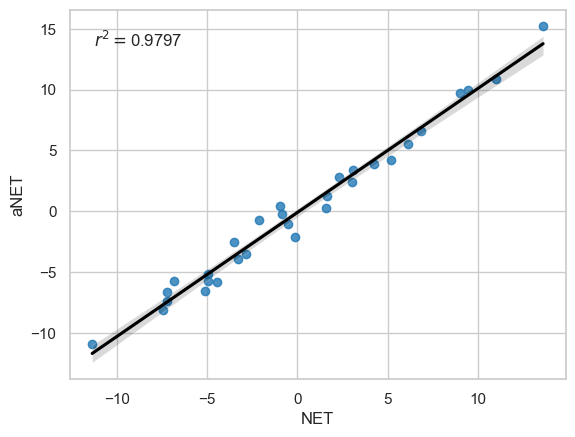

In [53]:
var1 = "NET"
# var1 = "OFF"
# var1 = "DEF"
var2 = "a" + var1
slope, intercept, r, p, sterr = scipy.stats.linregress(x=results[var1], y=results[var2])
r2 = r**2
fig, ax = plt.subplots(1,1)
fig = sns.regplot(x = var1, y = var2, data = results, color ="black",scatter_kws = {"color":"tab:blue"} ,ax=ax)
ax.text(0.05,0.9,r"$r^2=$"+f"{round(r2,4)}",transform = ax.transAxes)
plt.show()

In [58]:
import os
os.environ["R_HOME"] = "C:\\Program Files\\R\\R-4.3.2\\"
%reload_ext rpy2.ipython

c:\Users\pansr\AppData\Local\pypoetry\Cache\virtualenvs\nba-ub9Z_EQq-py3.11\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [80]:
results["OFF_R"] = results["OFF"].rank(ascending=False).astype(int)
results["DEF_R"] = results["DEF"].rank(ascending=True).astype(int)
results["NET_R"] = results["NET"].rank(ascending=False).astype(int)
results["aOFF_R"] = results["aOFF"].rank(ascending=False).astype(int)
results["aDEF_R"] = results["aDEF"].rank(ascending=True).astype(int)
results["aNET_R"] = results["aNET"].rank(ascending=False).astype(int)

In [93]:
%%R -i results 
library(tidyverse)
library(gt)
df <- results
df %>% 
  gt()%>%
  cols_move(OFF_R,OFF) %>% cols_move(DEF_R,DEF) %>% cols_move(NET_R,NET) %>%
  cols_move(aOFF_R,aOFF) %>% cols_move(aDEF_R,aDEF) %>% cols_move(aNET_R,aNET) %>%
  tab_header(
    title = md("**NBA Adjusted Net Rating Leaders 2023-24**"),
    subtitle = md("The Offensive, Defensive and Net Ratings are adjusted for Strength of Schedule" )
    ) %>%
    data_color(columns = c(OFF,aOFF,NET,aNET), palette = c("red", "green")) %>%
    data_color(columns = c(DEF,aDEF), palette = c("green","red")) %>%
    cols_align(align = "center",columns = c(OFF,DEF,NET,aOFF,aDEF,aNET))  %>%
    cols_label(
      OFF_R = "#",DEF_R = "#",NET_R = "#",aOFF_R = "#",aDEF_R = "#",aNET_R = "#"
    ) %>%
    tab_options(
        table.background.color = "floralwhite",
        column_labels.font.size = 12,
        column_labels.font.weight = 'bold',
        row_group.font.weight = 'bold',
        row_group.background.color = "#E5E1D8",
        table.font.size = 10,
        heading.title.font.size = 20,
        heading.subtitle.font.size = 12.5,
        table.font.names = "Consolas", 
        data_row.padding = px(2)
    ) %>% 
    tab_spanner(
      label = "Unadjusted",
      columns = c(OFF, OFF_R, DEF, DEF_R, NET, NET_R)
    ) %>%
    tab_spanner(
      label = "Adjusted",
      columns = c(aOFF, aOFF_R, aDEF, aDEF_R, aNET, aNET_R)
    ) %>%
    tab_source_note(
    source_note = "SOS adjustments done using Ridge Regression Method to estimate Off and Def Ratings" ) %>% 
    tab_source_note(
    source_note = "@SravanNBA | Source: nba.com/stats" ) %>% gtsave("../figs/team_leaders/Teams_aNET.png",zoom=5) 


file:///C:/Users/pansr/AppData/Local/Temp/RtmpIByU6A/file433c58723f5c.html screenshot completed
